# Programming Question: Predicting Housing Prices with Linear Regression

**Name:** Chen Yi Weng  
**USC ID:** 3769237784

## Data Exploration and Pre-processing

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### Part a (i): Load the Dataset

In [2]:

housing_df = pd.read_csv("../data/USA_Housing.csv")


### Part a (ii): Basic Data Exploration

In [3]:
# Display the first 5 rows
housing_df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386


In [4]:
# Show data types and non-null counts
housing_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              5000 non-null   float64
 1   Avg. Area House Age           5000 non-null   float64
 2   Avg. Area Number of Rooms     5000 non-null   float64
 3   Avg. Area Number of Bedrooms  5000 non-null   float64
 4   Area Population               5000 non-null   float64
 5   Price                         5000 non-null   float64
 6   Address                       5000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 273.6+ KB


In [5]:
# Descriptive statistics for numeric features
housing_df.describe()


,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,68583.108984,5.977222,6.987792,3.981330,36163.516039,1.232073e+06
std,10657.991214,0.991456,1.005833,1.234137,9925.650114,3.531176e+05
min,17796.631190,2.644304,3.236194,2.000000,172.610686,1.593866e+04
25%,61480.562388,5.322283,6.299250,3.140000,29403.928702,9.975771e+05
50%,68804.286404,5.970429,7.002902,4.050000,36199.406689,1.232669e+06
75%,75783.338666,6.650808,7.665871,4.490000,42861.290769,1.471210e+06
max,107701.748378,9.519088,10.759588,6.500000,69621.713378,2.469066e+06


In [6]:
# Check for missing values in each column
housing_df.isnull().sum()


Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Price                           0
Address                         0
dtype: int64

I loaded the `USA_Housing.csv` dataset into a DataFrame named `housing_df`.  
It contains 5000 entries with 7 columns. All columns are complete with no missing values.  
There are 6 numerical columns and 1 categorical column (`Address`).


### Part a (iii): Identify Features and Target Variable

In [7]:
# Define target and feature columns
target_column = 'Price'
feature_columns = [
    col for col in housing_df.select_dtypes(include='number').columns
    if col != target_column
]


The target variable is `Price`.  
The features (independent variables) are:
- `Avg. Area Income`
- `Avg. Area House Age`
- `Avg. Area Number of Rooms`
- `Avg. Area Number of Bedrooms`
- `Area Population`

### Part a (iv): Feature Engineering

In [8]:
# Create Avg_Area_Room_Per_Person = Rooms / Bedrooms
housing_df['Avg_Area_Room_Per_Person'] = (
    housing_df['Avg. Area Number of Rooms'] / housing_df['Avg. Area Number of Bedrooms']
)


In [9]:
# Extract 5-digit Zip Code (if available) from the Address column
housing_df['Zip_Code'] = housing_df['Address'].str.extract(r'(\d{5})').astype(float)


I made a new feature called `Avg_Area_Room_Per_Person`.
It is made by dividing the number of rooms by the number of bedrooms.
This shows how many rooms each bedroom has on average.
I think this might help show how large or nice the house is.

I also took out 5-digit zip codes from the `Address` column.
Even though `Address` is just text, the zip code can tell us something about the neighborhood.
Some areas may have higher house prices, so the zip code might be useful.

### Part a (v): Outlier Detection

In [10]:
# Use Z-score to detect outliers in the Price column
price_z = (housing_df['Price'] - housing_df['Price'].mean()) / housing_df['Price'].std()
housing_df_no_outliers = housing_df[price_z.abs() < 3]


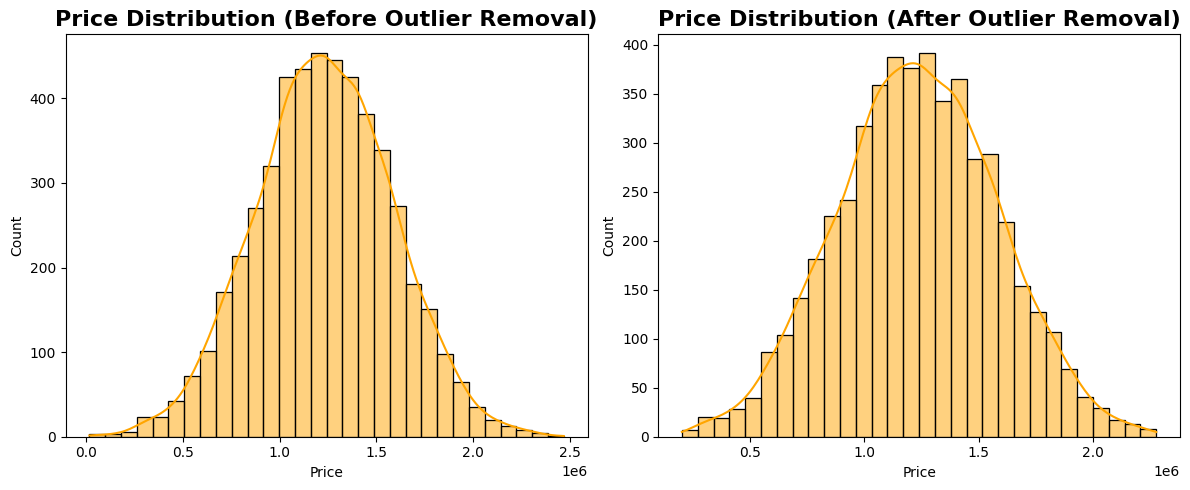

In [11]:
# Visualize Price distribution before and after removing outliers
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(housing_df['Price'], bins=30, kde=True, color='orange')
plt.title("Price Distribution (Before Outlier Removal)", fontsize=16, fontweight='bold')
plt.xlabel("Price")

plt.subplot(1, 2, 2)
sns.histplot(housing_df_no_outliers['Price'], bins=30, kde=True, color='orange')
plt.title("Price Distribution (After Outlier Removal)", fontsize=16, fontweight='bold')
plt.xlabel("Price")

plt.tight_layout()
plt.show()


To find outliers in the `Price` column, I used the **Z-score method**.

- First, I calculated the Z-score for each price.
- If the score was above 3 or below -3, I treated it as an outlier.
- Then I removed those rows to make the data more normal.

In the left chart, I show the price distribution **before** removing outliers.  
In the right chart, I show it **after** removing outliers.

- After removing the outliers, the shape looks smoother and more balanced.  
- This helps the model learn better and makes predictions more stable.


## Linear Regression Model

### Part b (i): Split the Dataset

In [12]:
# Prepare features and target using the cleaned dataset
final_features = feature_columns + ['Avg_Area_Room_Per_Person', 'Zip_Code']
X = housing_df_no_outliers[final_features]
y = housing_df_no_outliers['Price']

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


I picked seven features for my model.
This includes the new features `Avg_Area_Room_Per_Person` and `Zip_Code`.
Then, I split the data into two parts: 80% for training and 20% for testing.
I used `random_state=42` so I can get the same result every time I run it.

### Part b (ii): Create the Model

In [13]:
# Instantiate the Linear Regression model
linear_model = LinearRegression()


I made a basic `LinearRegression` model using scikit-learn.
This model is my starting point for predicting house prices.

### Part b (iii): Train the Model

In [14]:
# Fit the model to the training data
linear_model.fit(X_train, y_train)


LinearRegression()

I trained the model using the training data.
The model learned how the features are related to the house `Price`.

### Part b (iv): Predict on the Test Set

In [15]:
# Generate predictions on the test set
y_pred = linear_model.predict(X_test)

# Display first 5 predictions
y_pred[:5]


array([2022574.75338087, 1052336.54036221, 1809518.45013548,
        809263.16124465, 1309856.84167958])

- I used my trained model to predict house prices with the test data.
- Later, I will check if the predictions are good by using some evaluation scores.

## Regularization

### Part c (i): Train Ridge and Lasso Regression Models

In [16]:
# Try three alpha values for both Ridge and Lasso
alphas = [0.01, 1, 100]

# Train Ridge models
ridge_models = [Ridge(alpha=a) for a in alphas]
for model in ridge_models:
    model.fit(X_train, y_train)

# Train Lasso models (with high max_iter to ensure convergence)
lasso_models = [Lasso(alpha=a, max_iter=10000) for a in alphas]
for model in lasso_models:
    model.fit(X_train, y_train)


- I used Ridge and Lasso regression to see how regularization changes the model.
- I tried three different alpha values: 0.01, 1, and 100.

### Part c (ii): Compare Coefficients and Explain the Role of α

In [17]:
# Combine coefficients for comparison
coefficients_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Linear': linear_model.coef_,
    'Ridge (alpha=0.01)': ridge_models[0].coef_,
    'Ridge (alpha=1)': ridge_models[1].coef_,
    'Ridge (alpha=100)': ridge_models[2].coef_,
    'Lasso (alpha=0.01)': lasso_models[0].coef_,
    'Lasso (alpha=1)': lasso_models[1].coef_,
    'Lasso (alpha=100)': lasso_models[2].coef_,
})

coefficients_df


,Feature,Linear,Ridge (alpha=0.01),Ridge (alpha=1),Ridge (alpha=100),Lasso (alpha=0.01),Lasso (alpha=1),Lasso (alpha=100)
0,Avg. Area Income,21.511582,21.511581,21.511466,21.502924,21.511582,21.511578,21.511202
1,Avg. Area House Age,164602.268225,164601.837180,164559.177759,160414.935931,164602.257708,164601.216511,164497.096295
2,Avg. Area Number of Rooms,120815.184025,120813.977493,120695.516561,113555.376743,120815.105663,120807.341809,120030.846684
3,Avg. Area Number of Bedrooms,938.654699,940.264852,1097.966147,8801.068538,938.777068,950.901354,2163.510386
4,Area Population,15.225525,15.225525,15.225502,15.219272,15.225525,15.225528,15.225837
5,Avg_Area_Room_Per_Person,-3448.067879,-3445.033471,-3148.063148,10329.280269,-3447.806279,-3421.889405,-829.864005
6,Zip_Code,0.052468,0.052468,0.052473,0.051257,0.052468,0.052471,0.052731


I learned that the **alpha** value controls how much we limit the model.

- When **alpha is small** (like `0.01`), the model works almost like normal linear regression.
- When **alpha is big** (like `100`), it makes the model simpler by shrinking the coefficients.

I also saw the difference between **Ridge** and **Lasso**:

- **Ridge** makes the coefficient values smaller, but it does **not** make them zero.
- **Lasso** can make some coefficients exactly **zero**, so it helps the model pick only the important features.

### Part c (iii): Interpretation of Coefficient Differences

After looking at the coefficients from each model, I learned a few things:

- All models show similar results for the main features.
- When **alpha is large** (like `100`), **Ridge** makes the coefficients smaller, but still keeps all the features.
- **Lasso** with alpha = `100` makes some features almost zero.

This shows me that **Lasso is good for choosing important features**.  
If some features are not helpful, Lasso can remove them by setting their value to zero.


## Model Evaluation

### Part d (i) and (ii): Evaluate All Models on the Test Set

In [18]:
# Define evaluation function
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    return [mae, mse, rmse, r2]

# Apply to all models
model_names = [
    'Linear', 'Ridge (α=0.01)', 'Ridge (α=1)', 'Ridge (α=100)',
    'Lasso (α=0.01)', 'Lasso (α=1)', 'Lasso (α=100)'
]
models = [linear_model] + ridge_models + lasso_models

evaluation_results = [evaluate_model(m, X_test, y_test) for m in models]

# Organize into DataFrame
metrics_df = pd.DataFrame(evaluation_results, columns=['MAE', 'MSE', 'RMSE', 'R²'], index=model_names)
metrics_df


,MAE,MSE,RMSE,R²
Linear,82793.645520,1.073238e+10,103597.182844,0.913217
Ridge (α=0.01),82793.681340,1.073238e+10,103597.222989,0.913217
Ridge (α=1),82797.219605,1.073321e+10,103601.205462,0.913210
Ridge (α=100),83214.837330,1.082808e+10,104058.071045,0.912443
Lasso (α=0.01),82793.646141,1.073238e+10,103597.184294,0.913217
Lasso (α=1),82793.707739,1.073241e+10,103597.328019,0.913217
Lasso (α=100),82800.561779,1.073561e+10,103612.812182,0.913191


I tested all my models on the test data using four scores:

- **MAE (Mean Absolute Error)**: shows the average mistake.
- **MSE (Mean Squared Error)**: gives more weight to big mistakes.
- **RMSE (Root Mean Squared Error)**: similar to MSE but easier to understand.
- **R² (R-squared)**: tells me how well the model explains the prices.

From the results table, I saw that:

- The basic linear model and Ridge/Lasso (with α = 0.01 or 1) work almost the same.
- But when α = 100, Ridge did worse. The model became too simple and lost accuracy.

So, I think small alpha values work best for this dataset.


### Part d (iii): Interpretation of Metrics

Here is what I learned from the scores:

- A lower **MAE** or **RMSE** means my predictions are more accurate.
- A lower **MSE** helps me see if there are some big mistakes.
- A higher **R²** means the model explains the house prices better.

So, I want a model with **low errors** (MAE, MSE, RMSE) and a **high R² score**.  
That kind of model will give me the best and most reliable results.


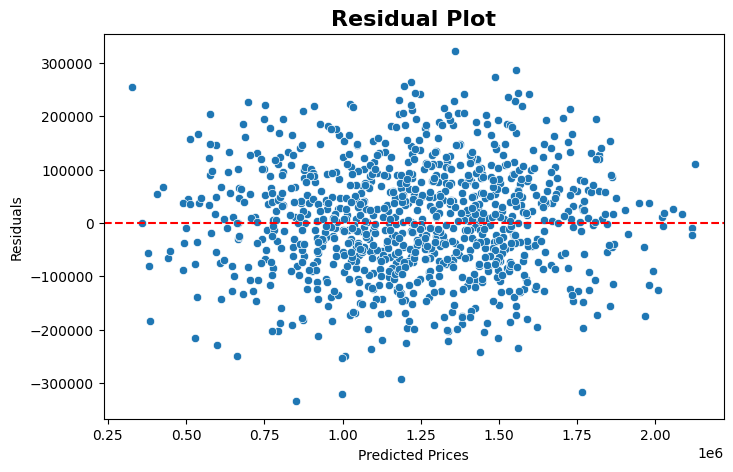

In [19]:
# Residuals = true - predicted
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.show()


This is the residual plot of my linear regression model.

- The blue dots are the **residuals** (real price - predicted price).
- The red line shows **zero error**.
- Most dots are close to the red line and spread **evenly**.

This means:

- The model does not have clear bias.  
- There is **no big pattern**, like a curve or funnel.  
- The errors look **random**, which is a good sign.

So I think my model is doing a good job. It makes predictions that are close to the real prices.


### Part d (iv): Cross-Validation

In [20]:
# Perform 5-fold CV on best-performing model (Linear)
cv_scores = cross_val_score(linear_model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

cv_mean, cv_std


(0.9155499069224062, 0.003059899585969233)

To make sure my model works well on different data, I used **5-fold cross-validation**.

- The **average R² score** from the 5 tests was `0.916`.
- The **standard deviation** was `0.003`, which is very small.

This tells me that my model is stable.  
It gives good results even when the data changes a little.

I think cross-validation is better than just one train-test split,  
because it checks the model on many different parts of the data.


## Coefficients and Intercept

### Part e (i): Display Coefficients and Intercept

In [21]:
# Show coefficients of the linear regression model
linear_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': linear_model.coef_
})

# Show intercept
linear_intercept = linear_model.intercept_

linear_coefficients, linear_intercept


(                        Feature    Coefficient
 0              Avg. Area Income      21.511582
 1           Avg. Area House Age  164602.268225
 2     Avg. Area Number of Rooms  120815.184025
 3  Avg. Area Number of Bedrooms     938.654699
 4               Area Population      15.225525
 5      Avg_Area_Room_Per_Person   -3448.067879
 6                      Zip_Code       0.052468,
 -2622853.182066202)

I printed the coefficients of each feature and the intercept of my linear regression model.

The intercept is **-2,622,853**, which means if all features were zero, the model would predict a negative price.  
This value has no real meaning on its own, but it helps adjust the baseline of predictions.


### Part e (ii): Interpret the Coefficients

Each coefficient shows how much the predicted price changes when one feature increases by one unit, while other features stay the same.

Here are some examples from my model:

- `Avg. Area Income`: For every 1 dollar increase in income, the housing price goes up by about **$21.51**.
- `Avg. Area House Age`: Older houses increase the price. For every extra year, the price goes up by about **$164,602**.
- `Avg. Area Number of Rooms`: More rooms strongly increase price. Each extra room adds about **$120,815**.
- `Avg. Area Number of Bedrooms`: Each extra bedroom adds about **$939**, which is small compared to rooms.
- `Area Population`: A larger population adds a small increase. Each extra person adds **$15.23**.
- `Avg_Area_Room_Per_Person`: This value is **negative**. If there are more rooms per person, the price slightly goes **down** by **$3,448**.
- `Zip_Code`: This coefficient is close to **0**, meaning zip code has almost no effect in this form.

In summary, features like income, number of rooms, and house age have the biggest positive effect on price.
